<img src="../images/logos/arm_logo.png" width=500 alt="ARM Logo"></img>

# Py-ART Gridding 
---

## Overview
   
Within this notebook, we will cover:

1. What is gridding and why is it important?
1. An overview of gridding with Py-ART  
1. Test out a different gridding routine
1. Apply Gridding to a Selection of Files


## Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| [Py-ART Basics](pyart-basics) | Helpful | Basic features |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Helpful | Basic features |
| [Matplotlib Basics](https://foundations.projectpythia.org/core/matplotlib/matplotlib-basics.html) | Helpful | Basic plotting |
| [NumPy Basics](https://foundations.projectpythia.org/core/numpy/numpy-basics.html) | Helpful | Basic arrays |

- **Time to learn**: 15 minutes
---

## Imports

In [50]:
import os
from pathlib import Path
import glob
import warnings

import cartopy.crs as ccrs
import matplotlib.pyplot as plt


import pyart
from pyart.testing import get_test_data
import xarray as xr

warnings.filterwarnings('ignore')

## What is gridding and why is it important?

### Antenna vs. Cartesian Coordinates

Radar data, by default, is stored in a **polar (or antenna) coordinate system**, with the data coordinates stored as an angle (ranging from 0 to 360 degrees with 0 == North), and a radius from the radar, and an elevation which is the angle between the ground and the ground.

This format can be challenging to plot, since it is scan/radar specific. Also, it can make comparing with model data, which is on a lat/lon grid, challenging since one would need to **transform** the model daa cartesian coordinates to polar/antenna coordiantes.

Fortunately, PyART has a variety of gridding routines, which can be used to **grid your data to a Cartesian grid**. Once it is in this new grid, one can easily slice/dice the dataset, and compare to other data sources.

### Why is Gridding Important?

Gridding is essential to combining multiple data sources (ex. multiple radars), and comparing to other data sources (ex. model data). There are also decisions that are made during the gridding process that have a large impact on the regridded data - for example:
- What resolution should my grid be?
- Which interpolation routine should I use?
- How smooth should my interpolated data be?

While there is not always a right or wrong answer, it is important to understand the options available, and document which routine you used with your data! Also - experiment with different options and choose the best for your use case!



## An overview of gridding with Py-ART
Let's dig into the regridding process with PyART!

### Read in and Visualize a Test Dataset
Let's start with the same file used in the previous notebook (`PyART Basics`), which is a radar file from Northern Oklahoma.

In [2]:
file = "../../data/uah-armor/RAW_NA_000_125_20080411182229"
radar = pyart.io.read(file)

Let's plot up quick look of reflectivity, at the lowest elevation scan (closest to the ground)

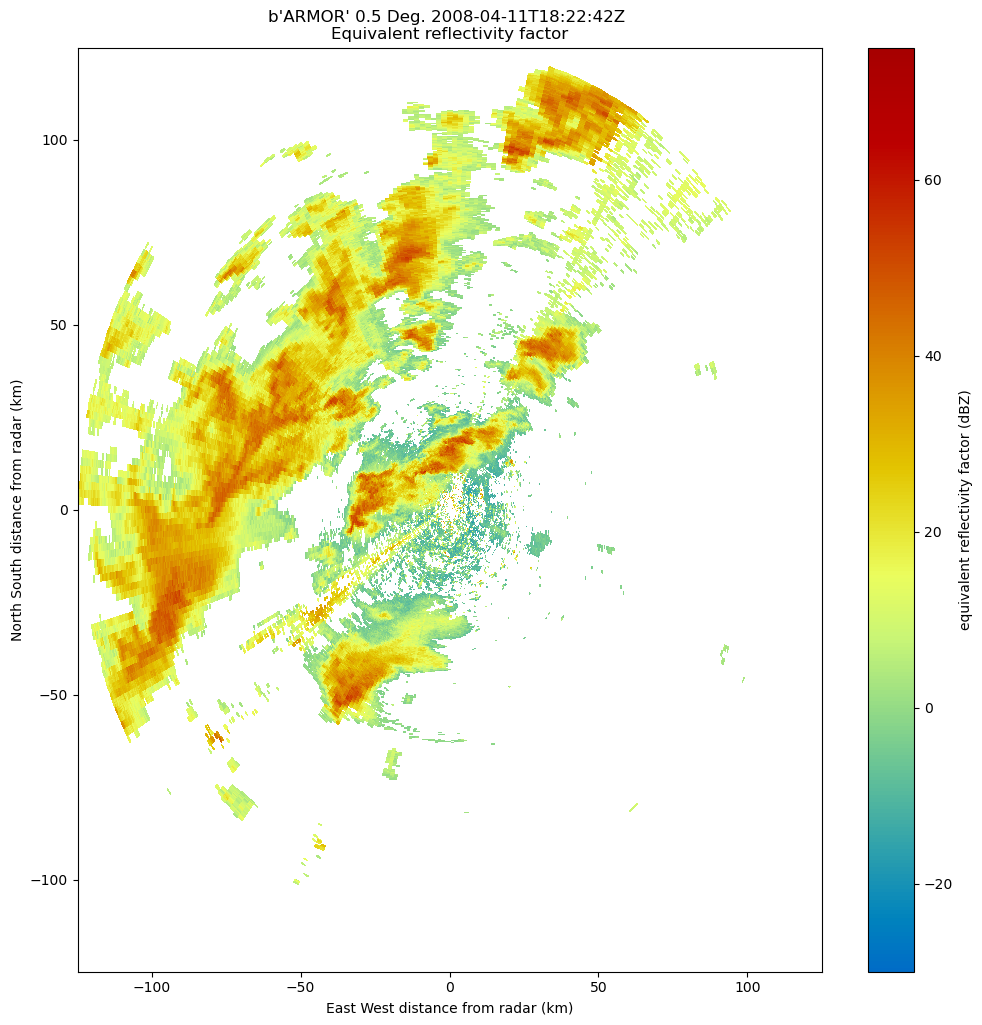

In [3]:
fig = plt.figure(figsize=[12, 12])
display = pyart.graph.RadarDisplay(radar)
display.plot_ppi('reflectivity',
                 cmap='pyart_HomeyerRainbow')

As mentioned before, the dataset is currently in the **antenna coordinate system** measured as distance from the radar

### Setup our Gridding Routine with `pyart.map.grid_from_radars()`

Py-ART has the [Grid object](https://arm-doe.github.io/pyart/API/generated/pyart.core.Grid.html#pyart.core.Grid) which has characteristics similar to that of the [Radar object](https://arm-doe.github.io/pyart/API/generated/pyart.core.Radar.html), except that the data are stored in Cartesian coordinates instead of the radar's antenna coordinates.

In [4]:
pyart.core.Grid?

Init signature:
pyart.core.Grid(
    time,
    fields,
    metadata,
    origin_latitude,
    origin_longitude,
    origin_altitude,
    x,
    y,
    z,
    projection=None,
    radar_latitude=None,
    radar_longitude=None,
    radar_altitude=None,
    radar_time=None,
    radar_name=None,
)
Docstring:     
A class for storing rectilinear gridded radar data in Cartesian coordinate.

Refer to the attribute section for information on the parameters.

To create a Grid object using legacy parameters present in Py-ART version
1.5 and before, use :py:func:`from_legacy_parameters`,
grid = Grid.from_legacy_parameters(fields, axes, metadata).

Attributes
----------
time : dict
    Time of the grid.
fields : dict of dicts
    Moments from radars or other variables.
metadata : dict
    Metadata describing the grid.
origin_longitude, origin_latitude, origin_altitude : dict
    Geographic coordinate of the origin of the grid.
x, y, z : dict, 1D
    Distance from the grid origin for each Cartesian

We can **transform our data** into this grid object, from the radars, using `pyart.map.grid_from_radars()`.

Beforing gridding our data, we need to make a decision about the desired grid resolution and extent. For example, one might imagine a grid configuration of:
- Grid extent/limits
    - 20 km in the x-direction (north/south)
    - 20 km in the y-direction (west/east)
    - 15 km in the z-direction (vertical)
- 500 m spatial resolution

The `pyart.map.grid_from_radars()` function takes the grid shape and grid limits as input, with the order `(z, y, x)`.

Let's setup our configuration, setting our grid extent **first**, with the distance measured in **meters**

In [5]:
z_grid_limits = (0.,15_000.)
y_grid_limits = (-150_000.,150_000.)
x_grid_limits = (-150_000.,150_000.)

Now that we have our grid limits, we can set our desired resolution (again, in meters)

In [6]:
grid_resolution = 500

Let's compute our grid shape - using the extent and resolution to compute the number of grid points in each direction.

In [7]:
def compute_number_of_points(extent, resolution):
    return int((extent[1] - extent[0])/resolution)

Now that we have a helper function to compute this, let's apply it to our vertical dimension

In [8]:
z_grid_points = compute_number_of_points(z_grid_limits, grid_resolution)
z_grid_points

30

We can apply this to the horizontal (x, y) dimensions as well.

In [9]:
x_grid_points = compute_number_of_points(x_grid_limits, grid_resolution)
y_grid_points = compute_number_of_points(y_grid_limits, grid_resolution)

print(z_grid_points,
      y_grid_points,
      x_grid_points)

30 600 600


#### Use our configuration to grid the data!
Now that we have the grid shape and grid limits, let's grid up our radar!

In [41]:
grid = pyart.map.grid_from_radars(radar,
                                  grid_shape=(z_grid_points,
                                              y_grid_points,
                                              x_grid_points),
                                  grid_limits=(z_grid_limits,
                                               y_grid_limits,
                                               x_grid_limits),
                                  fields=['reflectivity'],
                                  gridding_algo='map_gates_to_grid',
                                  h_factor=0.,
                                  nb=0.6,
                                  bsp=1.,
                                  min_radius=200.
                                 )
grid

We now have a `pyart.core.Grid` object!

### Plot up the Grid Object

#### Plot a horizontal view of the data
We can use the `GridMapDisplay` from `pyart.graph` to visualize our regridded data, starting with a horizontal view (slice along a single vertical level)

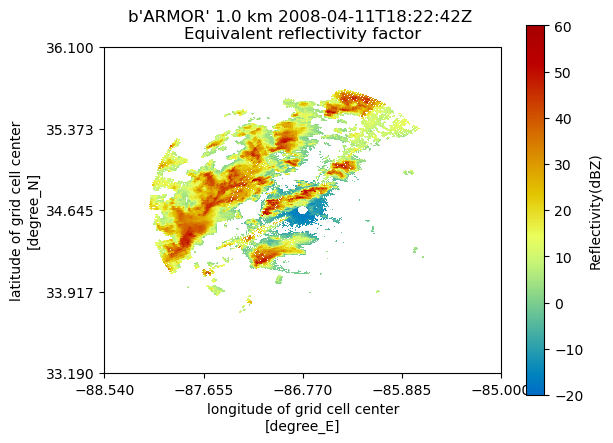

In [42]:
display = pyart.graph.GridMapDisplay(grid)
display.plot_grid('reflectivity',
                  level=2,
                  vmin=-20,
                  vmax=60,
                  cmap='pyart_HomeyerRainbow')

#### Plot a Latitudinal Slice

We can also slice through a single latitude or longitude!

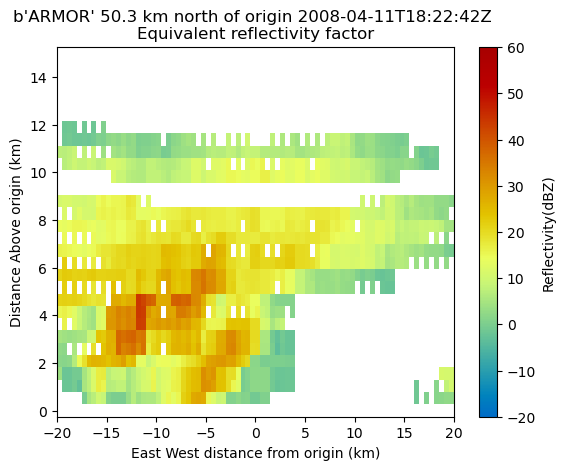

In [43]:
display.plot_latitude_slice('reflectivity',
                            lat=35.1,
                            vmin=-20,
                            vmax=60,
                            cmap='pyart_HomeyerRainbow')
plt.xlim([-20, 20]);

#### Plot with Xarray

Another neat feature of the `Grid` object is that we can transform it to an `xarray.Dataset`!

In [35]:
ds = grid.to_xarray()
ds

<xarray.Dataset>
Dimensions:       (time: 1, z: 30, y: 600, x: 600)
Coordinates:
  * time          (time) object 2008-04-11 18:22:42
  * z             (z) float64 0.0 517.2 1.034e+03 ... 1.448e+04 1.5e+04
    lat           (y, x) float64 33.29 33.29 33.29 33.29 ... 35.98 35.98 35.98
    lon           (y, x) float64 -88.39 -88.38 -88.37 ... -85.12 -85.11 -85.1
  * y             (y) float64 -1.5e+05 -1.495e+05 ... 1.495e+05 1.5e+05
  * x             (x) float64 -1.5e+05 -1.495e+05 ... 1.495e+05 1.5e+05
Data variables:
    reflectivity  (time, z, y, x) float32 nan nan nan nan ... nan nan nan nan
    ROI           (time, z, y, x) float32 2.222e+03 2.218e+03 ... 2.972e+03

Now, our plotting routine is a **one-liner**, starting with the horizontal slice:

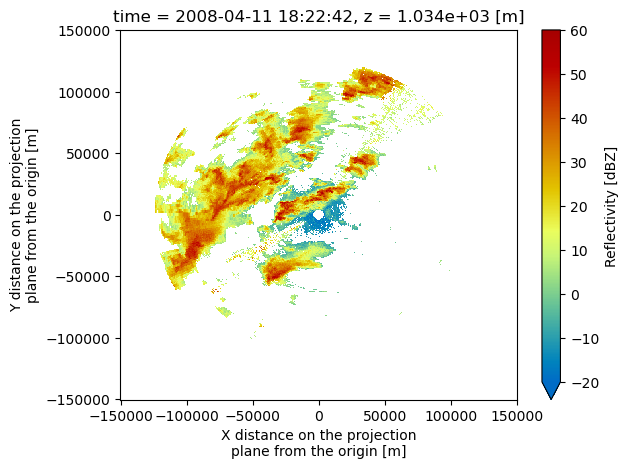

In [36]:
ds.isel(z=2).reflectivity.plot(cmap='pyart_HomeyerRainbow',
                               vmin=-20,
                               vmax=60);

And a vertical slice at a given y dimension (latitude)

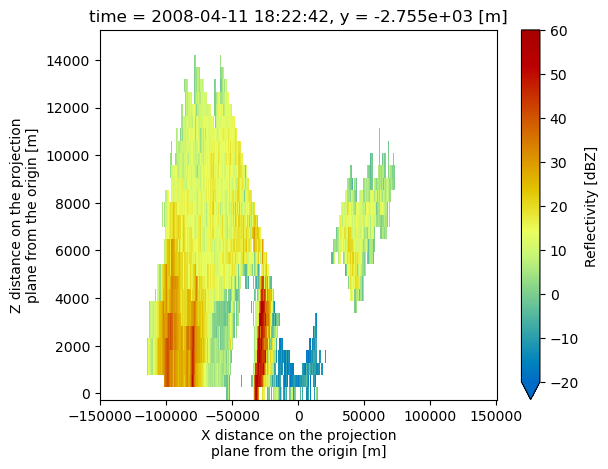

In [37]:
ds.sel(y=-3000,
       method='nearest').reflectivity.plot(cmap='pyart_HomeyerRainbow',
                                           vmin=-20,
                                           vmax=60);

### Try a Different Gridding Technique

In [39]:
nearest_grid = pyart.map.grid_from_radars(radar,
                                  grid_shape=(z_grid_points,
                                              y_grid_points,
                                              x_grid_points),
                                  grid_limits=(z_grid_limits,
                                               y_grid_limits,
                                               x_grid_limits),
                                  fields=['reflectivity'],
                                  weighting_function='Nearest',
                                  nb=0.6,
                                  bsp=1.,
                                  min_radius=200.
                                 )

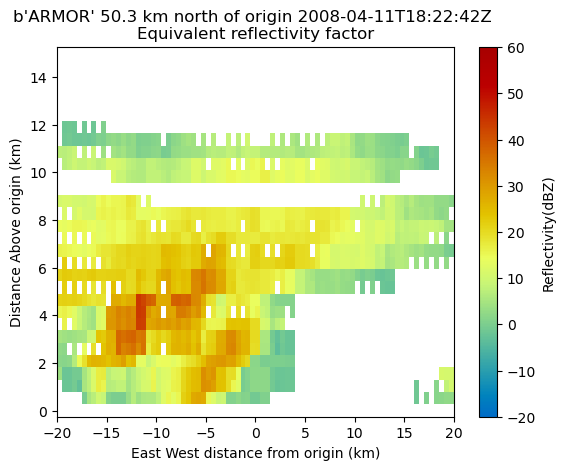

In [44]:
display.plot_latitude_slice('reflectivity',
                            lat=35.1,
                            vmin=-20,
                            vmax=60,
                            cmap='pyart_HomeyerRainbow')
plt.xlim([-20, 20]);

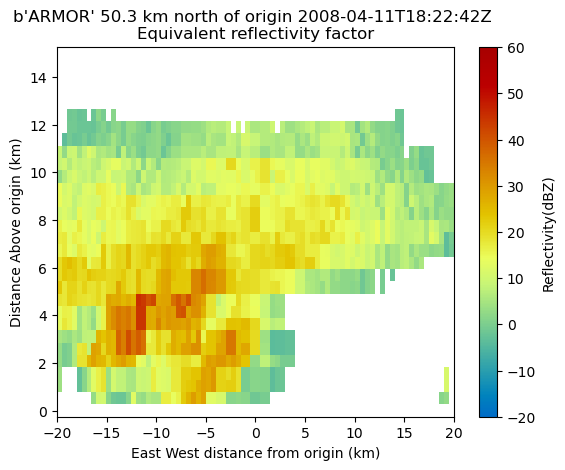

In [40]:
display = pyart.graph.GridMapDisplay(nearest_grid)
display.plot_latitude_slice('reflectivity',
                            lat=35.1,
                            vmin=-20,
                            vmax=60,
                            cmap='pyart_HomeyerRainbow')
plt.xlim([-20, 20]);

## Apply Gridding to a Selection of Files

We would like to apply our gridding transformation to an entire list of files, that will enable tracking in future notebooks (ex. tobac). We need to:
- Setup a function to grid our data (including saving it to disk)
- Provide a list of files to grid

In [45]:
def grid_radar_data(infile, outdir, grid_resolution=500):
    """
    Parameters
    ==========
    infile: string, path to file to be gridded
    outdir: string, path to directory to save to
    grid_resolution: int, desired resolution of field in meters
    
    Returns
    =======
    print statement with saved file
    """
    
    # Read the data
    radar = pyart.io.read(infile)
    
    # Configure the bounds + compute points
    z_grid_limits = (0.,15_000.)
    y_grid_limits = (-150_000.,150_000.)
    x_grid_limits = (-150_000.,150_000.)
    x_grid_points = compute_number_of_points(x_grid_limits, grid_resolution)
    y_grid_points = compute_number_of_points(y_grid_limits, grid_resolution)
    z_grid_points = compute_number_of_points(z_grid_limits, grid_resolution)
    
    
    # Grid the radar data
    grid = pyart.map.grid_from_radars(radar,
                                  grid_shape=(z_grid_points,
                                              y_grid_points,
                                              x_grid_points),
                                  grid_limits=(z_grid_limits,
                                               y_grid_limits,
                                               x_grid_limits),
                                  fields=['reflectivity'],
                                  weighting_function='Nearest',
                                  nb=0.6,
                                  bsp=1.,
                                  min_radius=200.
                                 )
    
    infile_path = Path(infile)
    
    outfile = f"{outdir}/{infile_path.stem}.nc"
    
    # Save to disk
    grid.to_xarray().to_netcdf(outfile, mode='w')
    print(f"Done gridding + saving {outfile}")
    return outfile

In [46]:
import fsspec

fs = fsspec.filesystem("https")

In [47]:
files = ["RAW_NA_000_125_20080411181219",
         "RAW_NA_000_125_20080411181722",
         "RAW_NA_000_125_20080411182229",
         "RAW_NA_000_125_20080411182732",
         "RAW_NA_000_125_20080411183259",
         "RAW_NA_000_125_20080411183827",
         "RAW_NA_000_125_20080411184409",
         "RAW_NA_000_125_20080411184937",
         "RAW_NA_000_125_20080411185504",
         "RAW_NA_000_125_20080411190016",
         "RAW_NA_000_125_20080411190525",
         "RAW_NA_000_125_20080411191031",
         "RAW_NA_000_125_20080411191548",
         "RAW_NA_000_125_20080411192104",
         "RAW_NA_000_125_20080411192613",
         "RAW_NA_000_125_20080411193127",
         "RAW_NA_000_125_20080411193638",
         "RAW_NA_000_125_20080411194151",
         "RAW_NA_000_125_20080411194703",
         "RAW_NA_000_125_20080411195218",
         "RAW_NA_000_125_20080411195728",
         "RAW_NA_000_125_20080411200416",
         "RAW_NA_000_125_20080411200945",
         "RAW_NA_000_125_20080411201520",
         "RAW_NA_000_125_20080411202047"
        ]

In [19]:
import urllib.request
import glob

In [20]:
def download_file(file, outdir='../../data/uah-armor/'):
    urllib.request.urlretrieve(f"https://github.com/openradar/open-radar-data/raw/main/data/{file}", f"{outdir}{file}")
    return f"{outdir}{file}"

In [21]:
downloaded_files = [download_file(file) for file in files]

In [48]:
gridded_data = [grid_radar_data(file,
                                "../../data/uah-armor/gridded") for file in downloaded_files]
    

Done gridding + saving ../../data/uah-armor/gridded/RAW_NA_000_125_20080411181219.nc
Done gridding + saving ../../data/uah-armor/gridded/RAW_NA_000_125_20080411181722.nc
Done gridding + saving ../../data/uah-armor/gridded/RAW_NA_000_125_20080411182229.nc
Done gridding + saving ../../data/uah-armor/gridded/RAW_NA_000_125_20080411182732.nc
Done gridding + saving ../../data/uah-armor/gridded/RAW_NA_000_125_20080411183259.nc
Done gridding + saving ../../data/uah-armor/gridded/RAW_NA_000_125_20080411183827.nc
Done gridding + saving ../../data/uah-armor/gridded/RAW_NA_000_125_20080411184409.nc
Done gridding + saving ../../data/uah-armor/gridded/RAW_NA_000_125_20080411184937.nc
Done gridding + saving ../../data/uah-armor/gridded/RAW_NA_000_125_20080411185504.nc
Done gridding + saving ../../data/uah-armor/gridded/RAW_NA_000_125_20080411190016.nc
Done gridding + saving ../../data/uah-armor/gridded/RAW_NA_000_125_20080411190525.nc
Done gridding + saving ../../data/uah-armor/gridded/RAW_NA_000_12

### Read in the Gridded Data and Plot It
Now that we have our output, we can read all of it into the same `xarray.Dataset`, and visualize our data!

In [51]:
ds = xr.open_mfdataset(gridded_data).squeeze()

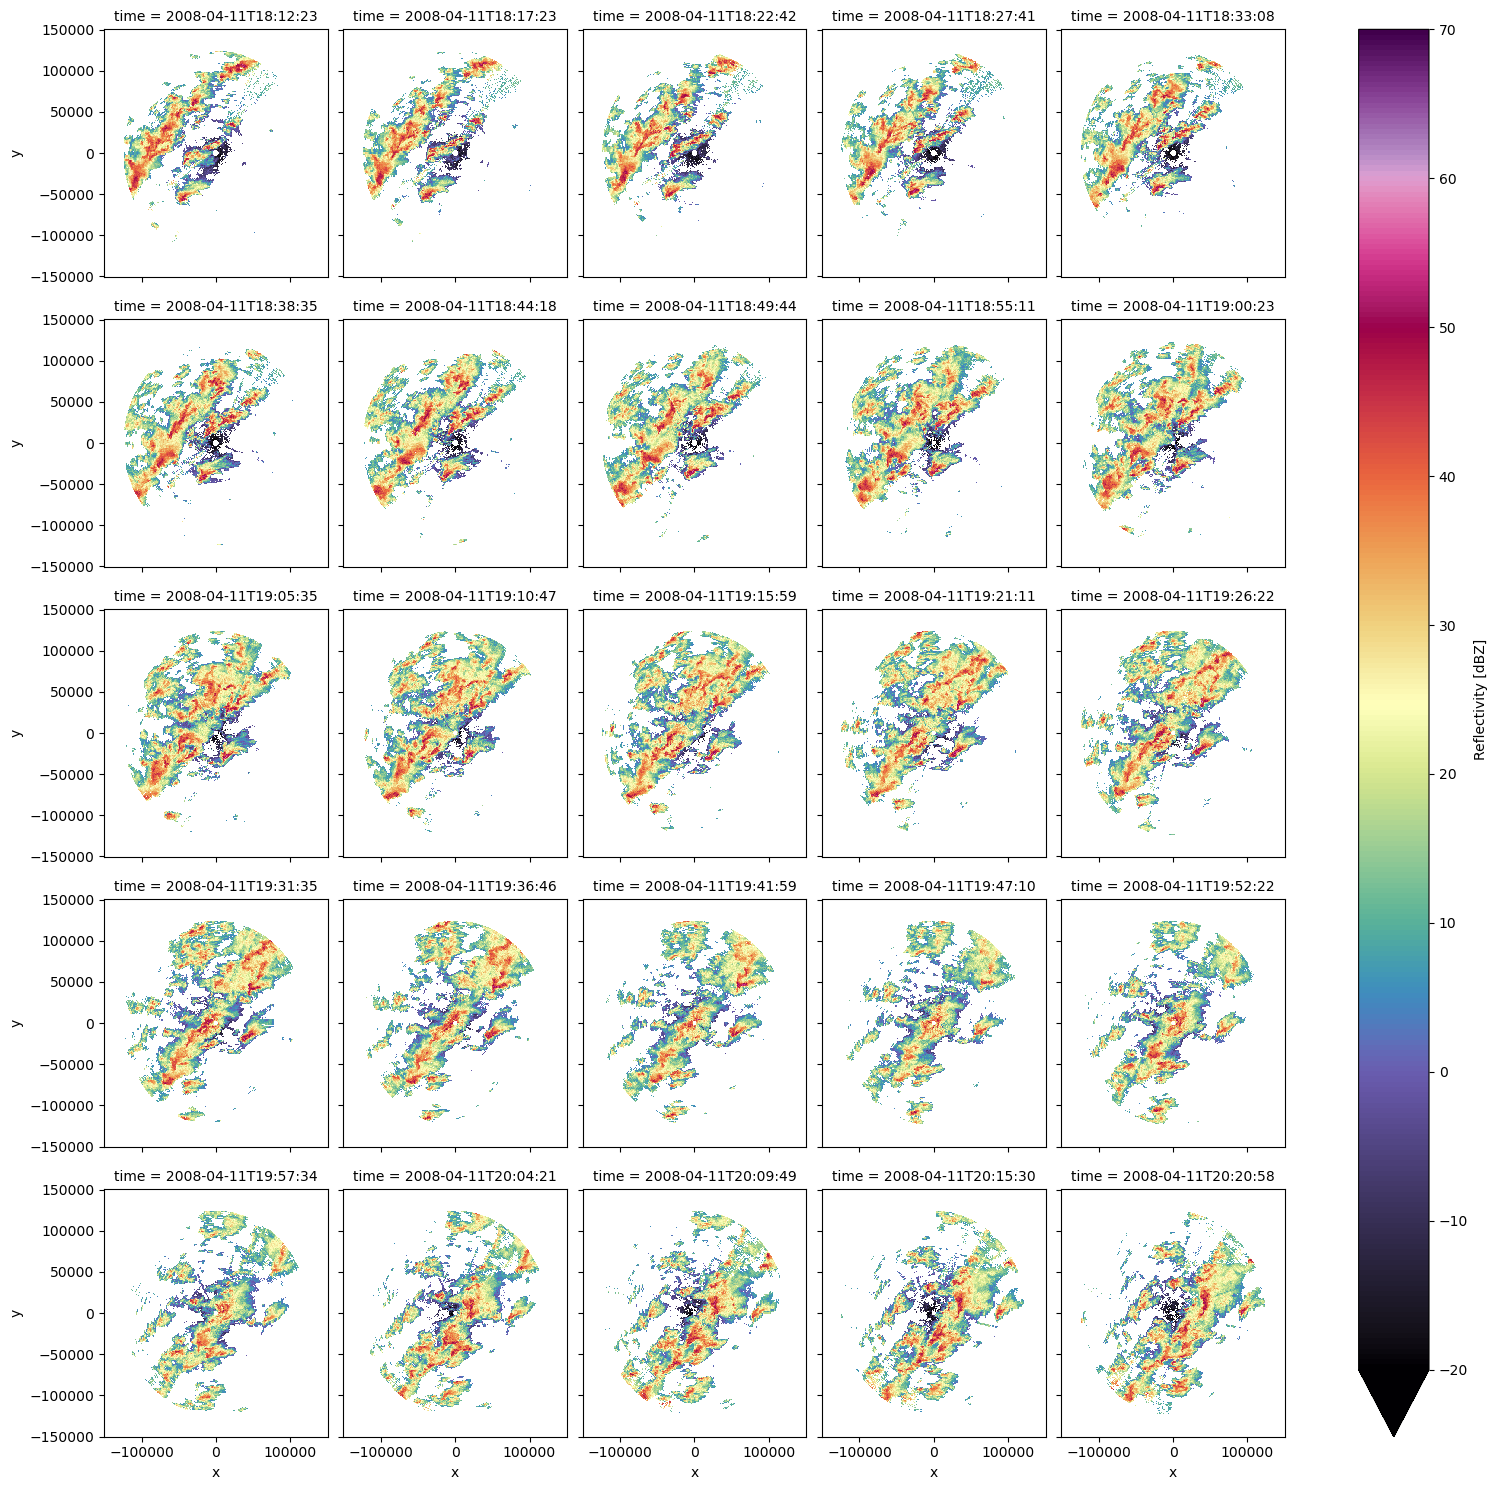

In [52]:
ds.reflectivity.isel(z=2).plot(x='x',
                               y='y',
                               col='time',
                               vmin=-20,
                               vmax=70,
                               cmap='pyart_ChaseSpectral',
                               col_wrap=5);

---
## Summary
Within this notebook, we covered the basics of gridding radar data using `pyart`, including:
- What we mean by gridding and why is it matters
- Configuring your gridding routine
- Visualize gridded radar data

### What's Next
In the next few notebooks, we walk through applying data cleaning methods, and advanced visualization methods!

## Resources and References
Py-ART essentials links:

* [Landing page](arm-doe.github.io/pyart/)
* [Examples](https://arm-doe.github.io/pyart/examples/index.html)
* [Source Code](github.com/ARM-DOE/pyart)
* [Mailing list](groups.google.com/group/pyart-users/)
* [Issue Tracker](github.com/ARM-DOE/pyart/issues)